In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pycaret.time_series import *
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
)
from statsmodels.tsa.deterministic import Fourier

# Load data
df = pd.read_csv("CSV\export-jsps013-1h.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"], format="mixed")
df.set_index("timestamp", inplace=True)

# # Keep only the last 1 year of data
# one_year_ago = df.index.max() - pd.DateOffset(years=1)
# df = df[df.index >= one_year_ago]

# Drop unnecessary columns
df.drop(columns=["timezone", "Unnamed: 0", "pm_2_5_sp","location" ,"pm_10"], inplace=True, errors="ignore")

# Resample to hourly and fill missing values

# Remove outliers using IQR
Q1 = df["pm_2_5"].quantile(0.25)
Q3 = df["pm_2_5"].quantile(0.75)
IQR = Q3 - Q1
df = df[(df["pm_2_5"] >= Q1 - 1.5 * IQR) & (df["pm_2_5"] <= Q3 + 1.5 * IQR)]

Q1t = df["temperature"].quantile(0.25)
Q3t = df["temperature"].quantile(0.75)
IQRt = Q3t - Q1t
df = df[(df["temperature"] >= Q1t - 1.5 * IQRt) & (df["temperature"] <= Q3t + 1.5 * IQRt)]

Q1h = df["humidity"].quantile(0.25)
Q3h = df["humidity"].quantile(0.75)
IQRh = Q3h - Q1h
df = df[(df["humidity"] >= Q1h - 1.5 * IQRh) & (df["humidity"] <= Q3h + 1.5 * IQRh)]
print(df)
df.interpolate(method="linear", inplace=True)

df = df.resample("D").mean().fillna(method="ffill")

# ✅ ปรับขนาดข้อมูลเป็น 4 ช่วงต่อวัน (ทุก 6 ชั่วโมง)
df = df.resample("D").mean()

# ✅ Fourier Terms (Weekly Seasonality) สำหรับ 4 ช่วงต่อวัน
fourier = Fourier(
    period=7, order=2
)  # Weekly seasonality with lower order (4 periods/day × 7 days)
fourier_features = fourier.in_sample(df.index)
df = pd.concat([df, fourier_features], axis=1)
df.dropna(inplace=True)

# ✅ เพิ่ม Lag Features หลายระดับ (Short-Term & Long-Term) สำหรับ 4 ช่วงต่อวัน
for lag in [
    7 +1,
    7 + 3,
    7 + 7,
    7 + 14,
]:  # 1 วัน, 2 วัน, 3 วัน, 7 วัน, 14 วัน (ปรับสเกลเป็น 4 ช่วงต่อวัน)
    df[f"pm_2_5_lag{lag}"] = df["pm_2_5"].shift(lag)
    df[f"humidity_lag{lag}"] = df["humidity"].shift(lag)
    df[f"temperature_lag{lag}"] = df["temperature"].shift(lag)

# ✅ เพิ่ม Rolling Mean และ Rolling Std หลายระดับ
for window in [2,3,5,7,14]:  # 1 วัน, 3 วัน, 7 วัน, 14 วัน (ปรับสเกลเป็น 4 ช่วงต่อวัน)
    df[f"pm_2_5_rollmean{window}"] = (
        df["pm_2_5"].shift(7).rolling(window=window, min_periods=1).mean()
    )
    df[f"pm_2_5_rollstd{window}"] = (
        df["pm_2_5"].shift(7).rolling(window=window, min_periods=1).std()
    )
    # df[f"temperature_rollmean{window}"] = (
    #     df["temperature"].shift(7).rolling(window=window, min_periods=1).mean()
    # )
    # df[f"temperature_rollstd{window}"] = (
    #     df["temperature"].shift(7).rolling(window=window, min_periods=1).std()
    # )
    df[f"humidity_rollmean{window}"] = (
        df["humidity"].shift(7).rolling(window=window, min_periods=1).mean()
    )
    df[f"humidity_rollstd{window}"] = (
        df["humidity"].shift(7).rolling(window=window, min_periods=1).std()
    )
    df[f"temperature_rollmean{window}"] = (
        df["temperature"].shift(7).rolling(window=window, min_periods=1).mean()
    )
    df[f"temperature_rollstd{window}"] = (
        df["temperature"].shift(7).rolling(window=window, min_periods=1).std()
    )

df = df.drop(columns=["temperature","humidity"])
df = df.asfreq("D").fillna(method="bfill")  # เติมข้อมูลก่อนแบ่ง


# แบ่งข้อมูลสำหรับฝึกและทดสอบ (7 วัน = 28 ช่วง)
train = df.iloc[:-7]  # แบ่ง train
test = df.iloc[-7:]  # แบ่ง test

# ✅ เลือกเฉพาะฟีเจอร์ที่สำคัญ
selected_features = ["pm_2_5"] + [col for col in df.columns if col != "pm_2_5"]
train = train[selected_features]
test = test[selected_features]

                      humidity     pm_2_5  temperature
timestamp                                             
2022-05-23 17:00:00  40.064772   4.397849    34.580538
2022-05-23 18:00:00  41.076264  10.216667    34.486000
2022-05-23 19:00:00  45.427888  17.800000    33.196083
2022-05-23 20:00:00  50.081478  16.183673    32.020612
2022-05-23 21:00:00  54.187730  17.366667    31.203000
...                        ...        ...          ...
2025-02-11 03:00:00  51.744323  21.016393    31.807705
2025-02-11 04:00:00  51.245643  18.901639    32.058033
2025-02-11 05:00:00  54.529598  17.557377    30.961639
2025-02-11 06:00:00  53.639700  16.281250    31.057500
2025-02-11 07:00:00  52.309167  21.913793    31.358276

[22406 rows x 3 columns]


--- Logging error ---
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\logging\__init__.py", line 1103, in emit
    stream.write(msg + self.terminator)
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\encodings\cp1252.py", line 19, in encode
    return codecs.charmap_encode(input,self.errors,encoding_table)[0]
UnicodeEncodeError: 'charmap' codec can't encode characters in position 293-310: character maps to <undefined>
Call stack:
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c:\Users\aufaw_nq8olti\Work\term

In [2]:
train


,pm_2_5,"sin(1,7)","cos(1,7)","sin(2,7)","cos(2,7)",pm_2_5_lag8,humidity_lag8,temperature_lag8,pm_2_5_lag10,humidity_lag10,...,humidity_rollmean7,humidity_rollstd7,temperature_rollmean7,temperature_rollstd7,pm_2_5_rollmean14,pm_2_5_rollstd14,humidity_rollmean14,humidity_rollstd14,temperature_rollmean14,temperature_rollstd14
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-05-23,14.872290,0.000000e+00,1.000000,0.000000e+00,1.000000,14.872290,50.177055,32.282703,14.872290,50.177055,...,50.177055,1.084568,32.282703,0.640880,14.872290,1.410580,50.177055,1.084568,32.282703,0.640880
2022-05-24,12.877429,7.818315e-01,0.623490,9.749279e-01,-0.222521,14.872290,50.177055,32.282703,14.872290,50.177055,...,50.177055,1.084568,32.282703,0.640880,14.872290,1.410580,50.177055,1.084568,32.282703,0.640880
2022-05-25,15.610691,9.749279e-01,-0.222521,-4.338837e-01,-0.900969,14.872290,50.177055,32.282703,14.872290,50.177055,...,50.177055,1.084568,32.282703,0.640880,14.872290,1.410580,50.177055,1.084568,32.282703,0.640880
2022-05-26,8.350055,4.338837e-01,-0.900969,-7.818315e-01,0.623490,14.872290,50.177055,32.282703,14.872290,50.177055,...,50.177055,1.084568,32.282703,0.640880,14.872290,1.410580,50.177055,1.084568,32.282703,0.640880
2022-05-27,11.391165,-4.338837e-01,-0.900969,7.818315e-01,0.623490,14.872290,50.177055,32.282703,14.872290,50.177055,...,50.177055,1.084568,32.282703,0.640880,14.872290,1.410580,50.177055,1.084568,32.282703,0.640880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-31,11.801709,-4.338837e-01,-0.900969,7.818315e-01,0.623490,16.127185,45.557018,34.429318,9.331062,46.034592,...,47.918957,3.763538,33.835763,0.815310,12.825756,6.334339,49.531001,3.969539,33.056063,1.063267
2025-02-01,17.364482,-9.749279e-01,-0.222521,4.338837e-01,-0.900969,5.506616,51.287634,33.879700,16.405614,44.361774,...,47.566104,3.451537,34.079743,0.548909,12.694879,6.364926,49.359175,3.922674,33.189797,1.078627
2025-02-02,18.723385,-7.818315e-01,0.623490,-9.749279e-01,-0.222521,10.466195,49.241716,34.173281,16.127185,45.557018,...,46.724383,2.659226,34.358787,0.372896,12.156431,6.438460,49.188112,3.988426,33.370494,1.148815


In [3]:
# ✅ เพิ่ม fold เป็น 5 เพื่อให้โมเดล Generalize ขึ้น
experiment = setup(
    data=train,
    target="pm_2_5",
    session_id=123,
    use_gpu=True,
    fh=7,  # Forecast horizon = 7 days (28 periods)
    fold=5,
    seasonal_period="D",
    verbose=True,
)
test.index = test.index.to_period("D")

# ✅ ลองโมเดล ARIMA ก่อน
arima_model = create_model("arima")
arima_model = tune_model(arima_model)
final_arima = finalize_model(arima_model)

# Predict using the finalized model
X_forecast = test.drop(columns=["pm_2_5"])

,Description,Value
0,session_id,123
1,Target,pm_2_5
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(989, 47)"
5,Transformed data shape,"(989, 47)"
6,Transformed train set shape,"(982, 47)"
7,Transformed test set shape,"(7, 47)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there a

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2024-12-24,0.8904,0.7421,5.3063,5.7313,0.9958,0.6585,-0.0869
1,2024-12-31,1.2972,1.1163,7.7253,8.6078,0.5455,0.8297,-7.7648
2,2025-01-07,1.1219,1.0430,6.6855,8.0390,0.3569,0.4871,-5.9454
3,2025-01-14,1.2835,1.1121,7.6359,8.5550,1.6698,0.6867,-0.7933
4,2025-01-21,0.8125,0.7428,4.8529,5.7378,0.7109,0.4773,-0.5794
Mean,NaT,1.0811,0.9513,6.4412,7.3342,0.8558,0.6279,-3.0340
SD,NaT,0.1989,0.1725,1.1787,1.3211,0.4579,0.1324,3.1808


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2024-12-24,1.0054,0.9492,5.9913,7.3305,1.6876,0.6565,-0.7780
1,2024-12-31,0.5298,0.4344,3.1555,3.3497,0.2229,0.2407,-0.3273
2,2025-01-07,0.7735,0.7098,4.6097,5.4705,0.2464,0.2988,-2.2162
3,2025-01-14,1.9807,1.7856,11.7835,13.7360,2.8199,0.8182,-3.6231
4,2025-01-21,1.0429,0.9375,6.2294,7.2414,0.6354,0.8068,-1.5157
Mean,NaT,1.0665,0.9633,6.3539,7.4256,1.1225,0.5642,-1.6921
SD,NaT,0.4927,0.4519,2.9292,3.4727,1.0015,0.2478,1.1604


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.6min finished


MAE: 3.70
MAPE: 44.56%
R2: -1.11
accurent: 55.44


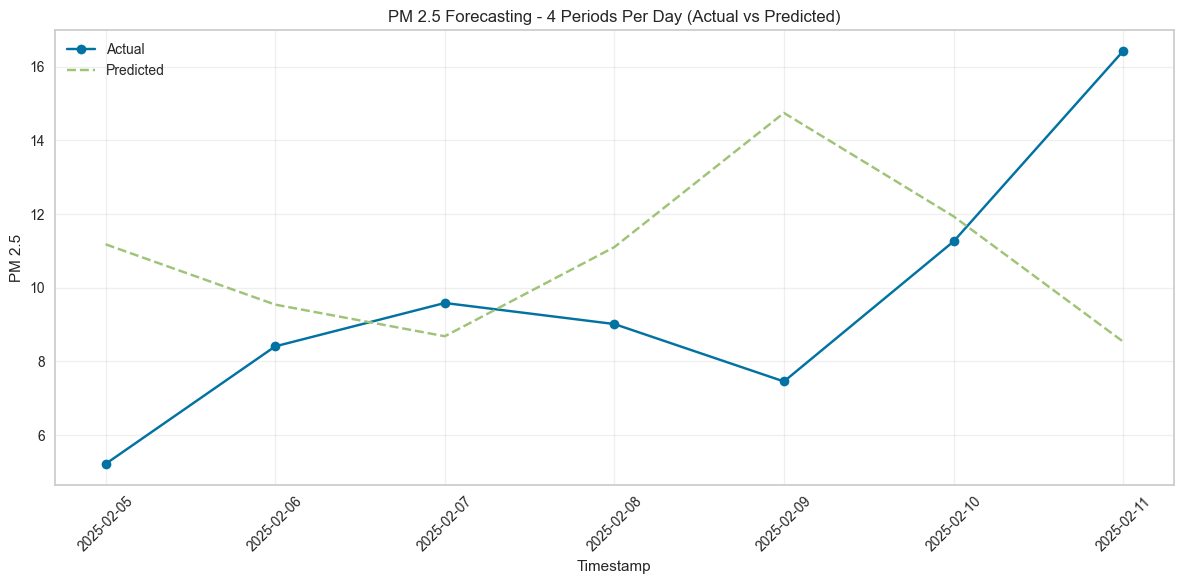

In [4]:
predictions = predict_model(final_arima, X=X_forecast)

# Evaluate Performance
mae = mean_absolute_error(test["pm_2_5"], predictions)
mape = mean_absolute_percentage_error(test["pm_2_5"], predictions) * 100
r2 = r2_score(test["pm_2_5"], predictions)
accurent = 100 - mape

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R2: {r2:.2f}")
print(f"accurent: {accurent:.2f}")

# ✅ แปลง Index ของ test ให้เป็น Timestamp ก่อนทำการ Plot
plt.figure(figsize=(12, 6))
plt.plot(
    test["pm_2_5"].index.to_timestamp(), test["pm_2_5"], label="Actual", marker="o"
)
plt.plot(
    test["pm_2_5"].index.to_timestamp(),
    predictions,
    label="Predicted",
    linestyle="--",
    marker="x",
)
plt.title("PM 2.5 Forecasting - 4 Periods Per Day (Actual vs Predicted)")
plt.xlabel("Timestamp")
plt.ylabel("PM 2.5")
plt.legend()
plt.grid(True, alpha=0.3)

# เพิ่มการแสดงช่วงเวลาให้ชัดเจนขึ้น
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [5]:
save_model(final_arima, "jsps013")

Transformation Pipeline and Model Successfully Saved


(ForecastingPipeline(steps=[('forecaster',
                             TransformedTargetForecaster(steps=[('model',
                                                                 ForecastingPipeline(steps=[('forecaster',
                                                                                             TransformedTargetForecaster(steps=[('model',
                                                                                                                                 ARIMA(order=(0,
                                                                                                                                              1,
                                                                                                                                              1),
                                                                                                                                       seasonal_order=(0,
                                                

In [ ]:
X_forecast.to_csv("jsps013_predic.csv")

: 